In [ ]:
'''
Import tickers for all S&P500 from Wikipedia
Download data from Yahoo Finance
For calculating beta, we only need the close price
Calculate the daily change in stock price from the daily close price
Calculate the rolling beta using daily change
Add in US6M rate to use as risk free rate
Calculate the Expected Returns for every stock, using the 1 year realized market returns as expected market returns
Calculate the Realized Returns for every stock over the past 1 year

Create a momentum strategy of going long the stocks with highest realized returns + expected returns
Results are in df8

Create a mean reversion strategy of going long the stocks with highest expected returns minus realized returns
Results are in df10

#df contains raw data downloaded from yfinance
#df1 contains close data for all S&P 500 stocks and the index
#df2 contains the daily return data for all S&P 500 stocks and the index
#df3 contains the calculated betas
#df4 contains the beta for all S&P 500 stocks, S&P return and US6M rate
#df5 contains the expected return for all S&P 500 stocks
#df6 contains the actual returns over the past 1 year
#df7 adds the expected returns to the 1 year historical realized returns
#df8 ranks every day the stock with the highest expected returns +realized returns
#df9 subtracts the 1 year historical realized returns from the expected returns
#df10 ranks every day the stock with the highest expected returns -realized returns
'''

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycaret

# Yahoo finance
import yfinance as yf

# Datetime
import datetime as dt
from datetime import datetime

In [33]:
start=pd.to_datetime('1990-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')
period=256           #lookback period for calculation of beta, realized returns

In [34]:
#Download data for multiple indicators available on Yahoo Finance

# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']
tickers=tickers.to_list()

print(tickers)
#print(tickers.head())



['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [35]:
#Two of the tickers have issue, also adding in S&P 500 index
for i in range(len(tickers)):
 
    # replace BF.B with BF-B
    if tickers[i] == 'BF.B':
        tickers[i] = 'BF-B'
 
    # replace BRK.B with BRK-B
    if tickers[i] == 'BRK.B':
        tickers[i] = 'BRK-B'

#Add S&P index
tickers.append("^GSPC")
# print list
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [36]:
tickers = yf.Tickers(tickers)

In [37]:
df = tickers.download(start=start,end=today_date,interval='1D',)   #['Adj Close']
#df contains raw data downloaded from yfinance
df

[*********************100%%**********************]  504 of 504 completed


Price            Close                                                         \
Ticker               A    AAL        AAPL        ABBV        ABNB         ABT   
Date                                                                            
1990-01-02         NaN    NaN    0.262722         NaN         NaN    1.809340   
1990-01-03         NaN    NaN    0.264485         NaN         NaN    1.815872   
1990-01-04         NaN    NaN    0.265367         NaN         NaN    1.812607   
1990-01-05         NaN    NaN    0.266249         NaN         NaN    1.793011   
1990-01-08         NaN    NaN    0.268012         NaN         NaN    1.802202   
...                ...    ...         ...         ...         ...         ...   
2024-05-30  131.419998  11.44  191.289993  156.309998  145.520004  101.739998   
2024-05-31  130.410004  11.50  192.250000  161.240005  144.929993  102.190002   
2024-06-03  131.399994  11.53  194.029999  160.190002  146.250000  102.870003   
2024-06-04  130.850006  11.50  194.350006  162.139999  147.080002  103.430000   
2024-06-05  133.559998  11.62  195.869995  165.440002  145.779999  103.230003   

Price                                                       ...   Volume  \
Ticker            ACGL         ACN        ADBE         ADI  ...       WY   
Date                                                        ...            
1990-01-02         NaN         NaN    1.188340    1.007656  ...   442400   
1990-01-03         NaN         NaN    1.247023    0.955311  ...   289700   
1990-01-04         NaN         NaN    1.305707    0.942224  ...   324200   
1990-01-05         NaN         NaN    1.335049    0.942224  ...   214000   
1990-01-08         NaN         NaN    1.352692    0.942224  ...   275400   
...                ...         ...         ...         ...  ...      ...   
2024-05-30  101.410004  284.799988  445.869995  229.088760  ...  2125500   
2024-05-31  102.629997  282.290009  444.760010  233.560974  ...  6134100   
2024-06-03  101.699997  281.760010  439.019989  231.290009  ...  2974200   
2024-06-04  100.860001  288.059998  448.369995  230.630005  ...  2485500   
2024-06-05   99.680000  291.019989  455.799988  235.679993  ...  2472400   

Price                                                                       \
Ticker           WYNN       XEL       XOM        XYL        YUM        ZBH   
Date                                                                         
1990-01-02        NaN    247200   5326000        NaN        NaN        NaN   
1990-01-03        NaN    126800   4980400        NaN        NaN        NaN   
1990-01-04        NaN    204200   6013200        NaN        NaN        NaN   
1990-01-05        NaN    144800   3854800        NaN        NaN        NaN   
1990-01-08        NaN    189000   4302000        NaN        NaN        NaN   
...               ...       ...       ...        ...        ...        ...   
2024-05-30  1219100.0   3206500  14692000  1751500.0  1587600.0  1731100.0   
2024-05-31  2004900.0  11067800  29037400  3015200.0  2282900.0  3003100.0   
2024-06-03  1197200.0   3195100  19589300  2466300.0  1618100.0  1662800.0   
2024-06-04  1522900.0   3460000  19412200  1078400.0  2125200.0  1186700.0   
2024-06-05  1332600.0   2474900  14861200   963500.0  1908000.0   918100.0   

Price                                        
Ticker          ZBRA        ZTS       ^GSPC  
Date                                         
1990-01-02       NaN        NaN   162070000  
1990-01-03       NaN        NaN   192330000  
1990-01-04       NaN        NaN   177000000  
1990-01-05       NaN        NaN   158530000  
1990-01-08       NaN        NaN   140110000  
...              ...        ...         ...  
2024-05-30  233800.0  2904700.0  3818750000  
2024-05-31  507200.0  4088400.0  5437160000  
2024-06-03  305600.0  2142700.0  4046920000  
2024-06-04  219500.0  1304400.0  3707900000  
2024-06-05  248000.0  1870800.0  3591460000  

[8673 rows x 3528 columns]

In [38]:
list(df.columns.levels[0])

['Close', 'Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume']

In [39]:
df1=df['Close']

In [40]:
#df1 contains close data for all S&P 500 stocks and the index
df1

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,0.262722,NaN,NaN,1.809340,NaN,NaN,1.188340,1.007656,...,3.252946,NaN,4.096443,3.929669,NaN,NaN,NaN,NaN,NaN,359.690002
1990-01-03,NaN,NaN,0.264485,NaN,NaN,1.815872,NaN,NaN,1.247023,0.955311,...,3.181293,NaN,4.083797,3.890373,NaN,NaN,NaN,NaN,NaN,358.760010
1990-01-04,NaN,NaN,0.265367,NaN,NaN,1.812607,NaN,NaN,1.305707,0.942224,...,3.152633,NaN,3.982652,3.851076,NaN,NaN,NaN,NaN,NaN,355.670013
1990-01-05,NaN,NaN,0.266249,NaN,NaN,1.793011,NaN,NaN,1.335049,0.942224,...,3.138303,NaN,3.944722,3.831426,NaN,NaN,NaN,NaN,NaN,352.200012
1990-01-08,NaN,NaN,0.268012,NaN,NaN,1.802202,NaN,NaN,1.352692,0.942224,...,3.138303,NaN,3.906791,3.890373,NaN,NaN,NaN,NaN,NaN,353.790009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,131.419998,11.44,191.289993,156.309998,145.520004,101.739998,101.410004,284.799988,445.869995,229.088760,...,29.519999,92.540001,54.320000,113.989998,139.399994,134.839996,114.440002,316.619995,169.440002,5235.479980
2024-05-31,130.410004,11.50,192.250000,161.240005,144.929993,102.190002,102.629997,282.290009,444.760010,233.560974,...,30.030001,94.879997,55.450001,117.260002,141.020004,137.429993,115.150002,312.339996,169.559998,5277.509766
2024-06-03,131.399994,11.53,194.029999,160.190002,146.250000,102.870003,101.699997,281.760010,439.019989,231.290009,...,29.709999,94.910004,55.279999,114.449997,138.610001,139.330002,113.120003,307.630005,172.369995,5283.399902


In [41]:
#Calculate the daily returns
df2 = np.log(df1/df1.shift(1))

In [43]:
#df2 contains the daily return data for all S&P 500 stocks and the index
df2

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.006688,NaN,NaN,0.003604,NaN,NaN,0.048202,-0.053346,...,-0.022273,NaN,-0.003092,-0.010050,NaN,NaN,NaN,NaN,NaN,-0.002589
1990-01-04,NaN,NaN,0.003331,NaN,NaN,-0.001800,NaN,NaN,0.045985,-0.013794,...,-0.009050,NaN,-0.025079,-0.010152,NaN,NaN,NaN,NaN,NaN,-0.008650
1990-01-05,NaN,NaN,0.003317,NaN,NaN,-0.010870,NaN,NaN,0.022223,0.000000,...,-0.004556,NaN,-0.009569,-0.005115,NaN,NaN,NaN,NaN,NaN,-0.009804
1990-01-08,NaN,NaN,0.006600,NaN,NaN,0.005113,NaN,NaN,0.013129,0.000000,...,0.000000,NaN,-0.009662,0.015268,NaN,NaN,NaN,NaN,NaN,0.004504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,-0.101640,-0.015612,0.005241,0.009772,-0.007462,0.009977,-0.001380,-0.031010,-0.068746,0.008076,...,0.012187,0.000108,0.018956,0.003163,0.013069,0.001262,-0.006098,-0.000979,-0.007994,-0.005993
2024-05-31,-0.007715,0.005231,0.005006,0.031053,-0.004063,0.004413,0.011959,-0.008852,-0.002493,0.019334,...,0.017129,0.024972,0.020589,0.028283,0.011554,0.019026,0.006185,-0.013610,0.000708,0.007996
2024-06-03,0.007563,0.002605,0.009216,-0.006533,0.009067,0.006632,-0.009103,-0.001879,-0.012990,-0.009771,...,-0.010713,0.000316,-0.003071,-0.024256,-0.017238,0.013731,-0.017786,-0.015195,0.016436,0.001115


In [42]:
#create a df3 to store the betas
#specify the lookback periods to calculate betas

df3=df2.copy()


In [44]:
#Loop through all the columns, then loop through all the rows (starting from period). Calculate for the period what is the beta and put it in df3

for j in range (df2.shape[1]-1):
    for i in range(1+period, len(df2)):
        try:
            s = df2.iloc[i-period:i,j] 
            m = df2.iloc[i-period:i,-1]  #check if SP500 is in last column or second last column of df2
            covariance = np.cov(s,m) 
            beta = covariance[0,1]/covariance[1,1]
            df3.iloc[i,j]= beta
        except IndexError:
            df3.iloc[i,j]= 0

In [45]:
#df3 contains the beta for all S&P 500 stocks
df3

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.006688,NaN,NaN,0.003604,NaN,NaN,0.048202,-0.053346,...,-0.022273,NaN,-0.003092,-0.010050,NaN,NaN,NaN,NaN,NaN,-0.002589
1990-01-04,NaN,NaN,0.003331,NaN,NaN,-0.001800,NaN,NaN,0.045985,-0.013794,...,-0.009050,NaN,-0.025079,-0.010152,NaN,NaN,NaN,NaN,NaN,-0.008650
1990-01-05,NaN,NaN,0.003317,NaN,NaN,-0.010870,NaN,NaN,0.022223,0.000000,...,-0.004556,NaN,-0.009569,-0.005115,NaN,NaN,NaN,NaN,NaN,-0.009804
1990-01-08,NaN,NaN,0.006600,NaN,NaN,0.005113,NaN,NaN,0.013129,0.000000,...,0.000000,NaN,-0.009662,0.015268,NaN,NaN,NaN,NaN,NaN,0.004504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,0.893499,1.445679,1.037339,0.312387,1.679391,0.432925,0.290803,0.980841,1.581042,1.414105,...,0.926831,1.167660,0.332393,0.222123,0.963544,0.671264,0.747209,1.569549,1.137470,-0.005993
2024-05-31,0.949811,1.445105,1.028318,0.294282,1.664301,0.409531,0.289093,0.995363,1.624446,1.403921,...,0.923723,1.119589,0.321271,0.234435,0.961857,0.651788,0.722027,1.552089,1.114576,0.007996
2024-06-03,0.908442,1.438711,1.032950,0.304508,1.659900,0.402362,0.282239,0.989276,1.616654,1.363953,...,0.920874,1.129932,0.328919,0.256288,0.949116,0.659810,0.718645,1.523202,1.103612,0.001115


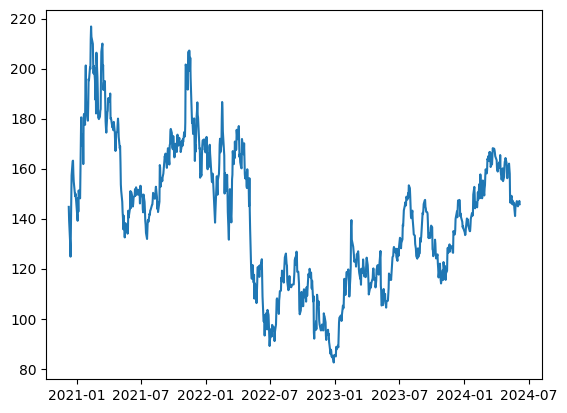

In [49]:
plt.plot(df1['ABNB'])

In [47]:
'''
CAPM

Rf= US 6m rate
Rm= S&P500

'''

In [61]:
#Data manually downloaded from investing.com

# Replace 'path/to/your/file.xlsx' with the actual path to your Excel file
US6M_file_path = '/Users/bennyang/Downloads/United States 6-Month Bond Yield Historical Data.csv'

# Use pandas to read the Excel file
US6M_df = pd.read_csv(US6M_file_path)

# Print the dataframe to verify it was read correctly
print(US6M_df)


            Date  Price   Open   High    Low Change %
0     06/06/2024  5.360  5.361  5.366  5.360    0.19%
1     06/05/2024  5.350  5.372  5.374  5.350   -0.11%
2     06/04/2024  5.356  5.369  5.391  5.356   -0.13%
3     06/03/2024  5.363  5.411  5.427  5.378   -0.11%
4     05/31/2024  5.369  5.413  5.432  5.379   -0.09%
...          ...    ...    ...    ...    ...      ...
4804  01/09/2006  4.364  4.364  4.364  4.364    0.48%
4805  01/06/2006  4.343  4.343  4.343  4.343   -0.28%
4806  01/05/2006  4.355  4.355  4.355  4.355    0.09%
4807  01/04/2006  4.351  4.351  4.351  4.351    0.32%
4808  01/03/2006  4.337  4.337  4.337  4.337    0.23%

[4809 rows x 6 columns]


In [62]:

US6M_df['Date'] = pd.to_datetime(US6M_df['Date'], format='mixed')
US6M_df.set_index('Date',inplace=True)
US6M_df.sort_index(ascending=True,inplace=True)
US6M_df.drop(['Open','High','Low','Change %'], axis=1, inplace=True)
US6M_df.rename(columns={"Price": "US6M"},inplace=True)
US6M_df['US6M']=US6M_df['US6M']/100
print(US6M_df)

               US6M
Date               
2006-01-03  0.04337
2006-01-04  0.04351
2006-01-05  0.04355
2006-01-06  0.04343
2006-01-09  0.04364
...             ...
2024-05-31  0.05369
2024-06-03  0.05363
2024-06-04  0.05356
2024-06-05  0.05350
2024-06-06  0.05360

[4809 rows x 1 columns]


In [63]:
df4 = df3.merge(US6M_df, on='Date', how='left')

In [86]:
#df4 contains the beta for all S&P 500 stocks, S&P return and US6M rate
df4

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC,US6M
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.006688,NaN,NaN,0.003604,NaN,NaN,0.048202,-0.053346,...,NaN,-0.003092,-0.010050,NaN,NaN,NaN,NaN,NaN,-0.002589,NaN
1990-01-04,NaN,NaN,0.003331,NaN,NaN,-0.001800,NaN,NaN,0.045985,-0.013794,...,NaN,-0.025079,-0.010152,NaN,NaN,NaN,NaN,NaN,-0.008650,NaN
1990-01-05,NaN,NaN,0.003317,NaN,NaN,-0.010870,NaN,NaN,0.022223,0.000000,...,NaN,-0.009569,-0.005115,NaN,NaN,NaN,NaN,NaN,-0.009804,NaN
1990-01-08,NaN,NaN,0.006600,NaN,NaN,0.005113,NaN,NaN,0.013129,0.000000,...,NaN,-0.009662,0.015268,NaN,NaN,NaN,NaN,NaN,0.004504,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,0.893499,1.445679,1.037339,0.312387,1.679391,0.432925,0.290803,0.980841,1.581042,1.414105,...,1.167660,0.332393,0.222123,0.963544,0.671264,0.747209,1.569549,1.137470,-0.005993,0.05374
2024-05-31,0.949811,1.445105,1.028318,0.294282,1.664301,0.409531,0.289093,0.995363,1.624446,1.403921,...,1.119589,0.321271,0.234435,0.961857,0.651788,0.722027,1.552089,1.114576,0.007996,0.05369
2024-06-03,0.908442,1.438711,1.032950,0.304508,1.659900,0.402362,0.282239,0.989276,1.616654,1.363953,...,1.129932,0.328919,0.256288,0.949116,0.659810,0.718645,1.523202,1.103612,0.001115,0.05363


In [84]:
#df5=df4['US6M']+df4*((df2['^GSPC'].rolling(period).sum())-df4['US6M'])
#df5=((df2['^GSPC'].rolling(period).sum())-df4['US6M'])

In [87]:
#create a df5 to store the expected returns

df5=df4.copy()

In [89]:
#Loop through all the columns, then loop through all the rows (starting from period). Calculate what is the rf, beta, market return to get expected return for the stock  

for j in range (df4.shape[1]-2):                     #all columns in df4 except last 2 columns
    for i in range(1+period, len(df4)):
        try:
            rf=df4.iloc[i,-1]                        #risk-free rate on that particular day
            beta=df4.iloc[i,j]                       #beta on that particular day
            market_return=df4.iloc[i-period:i,-2].sum()
            expected_returns=rf+beta*(market_return-rf)
            df5.iloc[i,j]= expected_returns
        except IndexError:
            df5.iloc[i,j]= 0

In [94]:
#df5 contains the expected return for all S&P 500 stocks
#drop the S&P500 and US6M rate
df5.drop(['^GSPC','US6M'], axis=1,inplace=True)
df5

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.006688,NaN,NaN,0.003604,NaN,NaN,0.048202,-0.053346,...,NaN,-0.022273,NaN,-0.003092,-0.010050,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,0.003331,NaN,NaN,-0.001800,NaN,NaN,0.045985,-0.013794,...,NaN,-0.009050,NaN,-0.025079,-0.010152,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,0.003317,NaN,NaN,-0.010870,NaN,NaN,0.022223,0.000000,...,NaN,-0.004556,NaN,-0.009569,-0.005115,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,0.006600,NaN,NaN,0.005113,NaN,NaN,0.013129,0.000000,...,NaN,0.000000,NaN,-0.009662,0.015268,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,0.209551,0.305842,0.234635,0.108215,0.346598,0.129235,0.104451,0.224782,0.329447,0.300336,...,0.125357,0.215364,0.257360,0.111704,0.092475,0.221766,0.170797,0.184041,0.327443,0.252096
2024-05-31,0.224396,0.313413,0.238505,0.106580,0.352808,0.127293,0.105647,0.232582,0.345645,0.306011,...,0.121153,0.219707,0.254909,0.111431,0.095824,0.226561,0.170833,0.183457,0.332640,0.254008
2024-06-03,0.230892,0.334362,0.255187,0.113048,0.377522,0.132142,0.108702,0.246665,0.369083,0.319774,...,0.128022,0.233317,0.274110,0.117811,0.103639,0.238828,0.182377,0.193857,0.350848,0.268975


In [95]:
#df6 contains the actual returns over the past 1 year
#Calculate the actual returns over the past 1 year
df6 = np.log(df1/df1.shift(period))
df6.drop(['^GSPC'], axis=1,inplace=True)
df6

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,0.028616,-0.206929,0.114154,0.132148,0.314519,-0.018491,0.326386,0.003751,0.185390,0.220985,...,0.141195,0.046465,-0.085660,-0.152188,0.103512,0.306978,0.049405,-0.122240,0.154772,-0.009182
2024-05-31,0.082211,-0.182322,0.117530,0.172860,0.315551,0.002130,0.357664,-0.000649,0.195557,0.321888,...,0.160284,0.084363,-0.052903,-0.124560,0.120673,0.348554,0.072853,-0.102925,0.178079,0.012181
2024-06-03,0.102249,-0.220886,0.120076,0.184414,0.336896,0.027193,0.340097,-0.019605,0.113130,0.316805,...,0.163983,0.078911,-0.051894,-0.114650,0.114519,0.353023,0.091256,-0.114315,0.169409,0.051945


In [97]:
#df7 adds the expected returns to the 1 year historical realized returns
#Momentum strategy - If expected returns is high and historical returns is high, stock should outperform moving forward
df7=df5+df6
df7

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,0.238167,0.098913,0.348789,0.240364,0.661117,0.110744,0.430837,0.228533,0.514837,0.521322,...,0.266553,0.261829,0.171701,-0.040484,0.195987,0.528744,0.220202,0.061800,0.482215,0.242913
2024-05-31,0.306606,0.131091,0.356035,0.279440,0.668359,0.129423,0.463311,0.231933,0.541202,0.627899,...,0.281437,0.304070,0.202006,-0.013130,0.216497,0.575115,0.243686,0.080532,0.510719,0.266189
2024-06-03,0.333140,0.113475,0.375262,0.297461,0.714418,0.159335,0.448800,0.227060,0.482213,0.636579,...,0.292005,0.312228,0.222216,0.003161,0.218157,0.591851,0.273632,0.079542,0.520257,0.320920


In [107]:
#df8 ranks every day the stock with the highest expected returns +realized returns
df8=df7.rank(axis=1)
df8

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,162.0,78.0,263.0,164.0,441.0,84.0,320.0,150.0,366.0,371.0,...,190.0,186.0,108.0,36.0,127.0,373.0,147.0,64.0,349.0,169.0
2024-05-31,201.0,80.0,245.0,174.0,436.0,79.0,320.0,134.0,367.0,410.0,...,176.0,199.0,111.0,32.0,119.0,385.0,145.0,61.0,347.0,159.0
2024-06-03,217.0,63.0,249.0,180.0,446.0,81.0,307.0,119.0,330.0,419.0,...,174.0,196.0,117.0,29.0,112.0,391.0,155.0,51.0,347.0,202.0


In [106]:
#df9 subtracts the 1 year historical realized returns from the expected returns
#Mean reversion strategy - If historical realized returns is high relative to expected returns, the stock should underperform moving forward. But if historical realized returns is poor but expected returns is high, the stock has room to outperform moving forward.
df9=df5-df6
df9

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,0.180936,0.512771,0.120480,-0.023933,0.032079,0.147726,-0.221935,0.221032,0.144057,0.079351,...,-0.015838,0.168899,0.343020,0.263891,-0.011038,-0.085212,0.121392,0.306281,0.172671,0.261278
2024-05-31,0.142185,0.495734,0.120976,-0.066280,0.037256,0.125164,-0.252016,0.233231,0.150087,-0.015878,...,-0.039130,0.135343,0.307812,0.235991,-0.024849,-0.121994,0.097981,0.286381,0.154562,0.241827
2024-06-03,0.128643,0.555248,0.135111,-0.071366,0.040625,0.104949,-0.231395,0.266269,0.255953,0.002969,...,-0.035961,0.154407,0.326005,0.232461,-0.010880,-0.114195,0.091121,0.308173,0.181439,0.217029


In [108]:
#df10 ranks every day the stock with the highest expected returns -realized returns
df10=df9.rank(axis=1)
df10

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,362.0,482.0,313.0,182.0,233.0,340.0,54.0,386.0,335.0,281.0,...,191.0,353.0,446.0,416.0,194.0,130.0,314.0,429.0,354.0,414.0
2024-05-31,352.0,483.0,333.0,158.0,266.0,336.0,47.0,410.0,358.0,209.0,...,186.0,346.0,443.0,412.0,202.0,118.0,313.0,432.0,361.0,414.0
2024-06-03,319.0,487.0,327.0,143.0,250.0,304.0,47.0,418.0,411.0,212.0,...,172.0,347.0,447.0,406.0,194.0,112.0,295.0,435.0,364.0,392.0
